# <font color='blue'>Mean Machine: Boosting a decision stump</font>

The goal of this notebook is to implement your own boosting module.

* Use pandas to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

# <font color='red'>Import all relevant packages</font>

In [1]:
import numpy as np     # 用来做数学运算
import pandas as pd    # 用来处理数据表

# 将所有图都在 Notebook 里显示
%matplotlib inline               
import matplotlib.pyplot as plt  # 用来画图
from sklearn.model_selection import train_test_split # 做交叉验证，划分训练集和测试集

# <font color='red'>Load Lending Club dataset</font>

We will be using the same [LendingClub](https://www.lendingclub.com/) dataset as in the previous assignment.

In [2]:
loans = pd.read_csv('lending-club-data.csv', low_memory=False)
loans.head(3).append(loans.tail(3))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.143500,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.393200,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.259550,20141201T000000,1,1,1
122604,9695736,11547808,8525,8525,8525,60 months,18.25,217.65,D,D3,...,0.6,0.0,1.0,1.0,0,6.958120,20190101T000000,0,1,0
122605,9684700,11536848,22000,22000,22000,60 months,19.97,582.50,D,D5,...,1.0,1.0,0.0,1.0,0,8.961540,20190101T000000,1,0,1
122606,9604874,11457002,2000,2000,2000,36 months,7.90,62.59,A,A4,...,0.8,0.0,1.0,1.0,0,0.904916,20170101T000000,0,1,1


### Extracting the target and the feature columns

We will now repeat some of the feature processing steps that we saw in the previous assignment:

First, we re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan.

Next, we select four categorical features: 
1. grade of the loan 
2. the length of the loan term
3. the home ownership status: own, mortgage, rent
4. number of years of employment.

In [3]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home_ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', 1)
target = 'safe_loans'
loans = loans[features + [target]]

### Subsample dataset to make sure classes are balanced

Just as we did in the previous assignment, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We use `seed=1` so everyone gets the same results.

In [4]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]

# Since there are fewer risky loans than safe loans, find the ratio of 
# the sizes and use that percentage to undersample the safe loans.
ratio = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=ratio, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

N1 = len(safe_loans)
N2 = len(risky_loans)
N = N1 + N2
print( "%% of safe loans  : %.2f%%" %(N1/N*100.0) )
print( "%% of risky loans : %.2f%%" %(N2/N*100.0) )
print( "Total number of loans in our new dataset :", N )

% of safe loans  : 50.00%
% of risky loans : 50.00%
Total number of loans in our new dataset : 46300


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

### Transform categorical data into binary features

In this assignment, we will work with **binary decision trees**. Since all of our features are currently categorical features, we want to turn them into binary features using 1-hot encoding. 

We can do so with the following code block (see the first assignments for more details):

In [5]:
categorical_variables = []
for feat_name, feat_type in zip(loans_data.columns.values,loans_data.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    feat_value = loans_data[feature].unique()
    loans_data_one_hot_encoded = pd.DataFrame()
    for val in feat_value:
        label = feature + '.' + val
        loans_data_one_hot_encoded[label] = loans_data[feature].apply(lambda x: 1 if x == val else 0)
    loans_data = pd.concat([loans_data, loans_data_one_hot_encoded], axis=1)
loans_data = loans_data.drop(categorical_variables,axis=1)

loans_data.head(3).append(loans_data.tail(3))        

,safe_loans,grade.C,grade.F,grade.B,grade.D,grade.A,grade.E,grade.G,term. 60 months,term. 36 months,...,emp_length.3 years,emp_length.10+ years,emp_length.1 year,emp_length.9 years,emp_length.2 years,emp_length.8 years,emp_length.7 years,emp_length.5 years,emp_length.n/a,emp_length.6 years
1,-1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,-1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,-1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
90431,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
115727,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
105752,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
features = loans_data.columns.values
features = features[features != target]
features

array(['grade.C', 'grade.F', 'grade.B', 'grade.D', 'grade.A', 'grade.E',
       'grade.G', 'term. 60 months', 'term. 36 months',
       'home_ownership.RENT', 'home_ownership.OWN',
       'home_ownership.MORTGAGE', 'home_ownership.OTHER',
       'emp_length.< 1 year', 'emp_length.4 years', 'emp_length.3 years',
       'emp_length.10+ years', 'emp_length.1 year', 'emp_length.9 years',
       'emp_length.2 years', 'emp_length.8 years', 'emp_length.7 years',
       'emp_length.5 years', 'emp_length.n/a', 'emp_length.6 years'], dtype=object)

### Train-test split

We split the data into training and test sets using an 80/20 split and specifying `random_state=0` so everyone gets the same results. Call the training and test sets train_data and test, respectively.

In [7]:
(train_data, test_data) = train_test_split( loans_data, 
                             train_size=0.8, random_state=0 )
print( train_data.shape, test_data.shape )

(37040, 26) (9260, 26)


# <font color='red'>Weighted decision trees</font>

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $u_1 ... u_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{u}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} u_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} u_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Write a function to compute weight of mistakes

Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $u_1 ... u_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{u}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} u_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{u}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{u}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} u_i}
$$

The function **count_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{u}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{u}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **count_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight.

In [8]:
def count_weighted_mistakes( labels_in_node, data_weights ):
    # Count the weight of 1's (safe loans)
    pos = np.array(labels_in_node == +1)
    counter1 = sum(data_weights[pos])
    
    # Count the weight of -1's (risky loans)
    neg = np.array(labels_in_node == -1)
    counter_1 = sum(data_weights[neg])

    # Return the weight of mistakes by majority rules
    return (counter_1,1) if counter1 >= counter_1 else (counter1,-1)

**Checkpoint:** Test your **count_weighted_mistakes** function, run the following cell:

In [9]:
example_labels = np.array([-1, -1, 1, 1, 1])
example_data_weights = np.array([1., 2., .5, 1., 1.])

if count_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print( 'Test passed!' )
else:
    print( 'Test failed... try again!' )

Test passed!


### Function to pick best feature to split on

The **best_splitting_feature** function is similar to the one from the ***decision tree notebook*** with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
  
Complete the following function. Comments starting with `DIFFERENT HERE` mark the sections where the weighted version differs from the original implementation.

In [10]:
def best_splitting_feature( data, features, target, data_weights ):
    best_feature = None
    best_error = 10

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        left = np.array( data[feature] == 0 )
        right = np.array( data[feature] == 1 )
        
        # The left (right) split will have all data points where the feature value is 0 (1)
        left_split = data[ left ]
        right_split = data[ right ] 
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = data_weights[ left ]
        right_data_weights = data_weights[ right ]
                    
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = count_weighted_mistakes( left_split[target], left_data_weights )
        right_weighted_mistakes, right_class = count_weighted_mistakes( right_split[target], right_data_weights )
        
        # Compute weighted error by computing
        error = (left_weighted_mistakes+right_weighted_mistakes) / (sum(left_data_weights)+sum(right_data_weights))
        
        if error < best_error:
            best_feature = feature
            best_error = error

    return best_feature  # Return the best feature we found

In [11]:
example_data_weights = np.ones(len(train_data))*1.5
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term. 60 months':
    print( 'Test passed!' )
else:
    print( 'Test failed... try again!' )

Test passed!


**Very Optional**. Relationship between weighted error and weight of mistakes

By definition, the weighted error is the weight of mistakes divided by the weight of all data points, so

$$
\mathrm{E}(\mathbf{u}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} u_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} u_i} = \frac{\mathrm{WM}(\mathbf{u}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} u_i}.
$$

In the code above, we obtain $\mathrm{E}(\mathbf{u}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{u}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{u}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$. First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{u}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split:

$$
\mathrm{WM}(\mathbf{u}, \mathbf{\hat{y}})
= \sum_{i=1}^{n} u_i \times 1[y_i \neq \hat{y_i}]
= \sum_{\mathrm{left}} u_i \times 1[y_i \neq \hat{y_i}]
 + \sum_{\mathrm{right}} u_i \times 1[y_i \neq \hat{y_i}]\\
= \mathrm{WM}(\mathbf{u}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{u}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})
$$

We then divide through by the total weight of all data points to obtain $\mathrm{E}(\mathbf{u}, \mathbf{\hat{y}})$:


$$
\mathrm{E}(\mathbf{u}, \mathbf{\hat{y}})
= \frac{\mathrm{WM}(\mathbf{u}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{u}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n} u_i}
$$

### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree.

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }

In [12]:
def create_leaf( target_values, data_weights ):
    
    leaf = {'splitting_feature' : None,
            'left': None,
            'right': None,
            'is_leaf': True}
    
    leaf['prediction'] = count_weighted_mistakes(target_values, data_weights)[1]
    
    return leaf

We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [13]:
def weighted_decision_tree( data, features, target, data_weights, current_depth = 1, max_depth = 10 ):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print( "--------------------------------------------------------------------" )
    print( "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)) )
    
    # Stopping condition 1. Error is almost 0.
    if count_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print( "Stopping condition 1 reached." )               
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if len(remaining_features) == 0:
        print( "Stopping condition 2 reached." )                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print( "Reached maximum depth. Stopping for now." )
        return create_leaf(target_values, data_weights)
    
    # Find the best splitting feature
    splitting_feature = best_splitting_feature( data, features, target, data_weights )
    
    left = np.array( data[splitting_feature] == 0 )
    right = np.array( data[splitting_feature] == 1 )
    
    left_split = data[ left ]
    right_split = data[ right ]
    
    left_data_weights = data_weights[ left ]
    right_data_weights = data_weights[ right ]
    
    remaining_features = remaining_features[remaining_features != splitting_feature]
    print( "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)) )
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print( "Creating leaf node." )
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print( "Creating leaf node." )
        return create_leaf(right_split[target], data_weights)
    
    # Repeat on left and right subtrees
    left_tree = weighted_decision_tree( left_split, remaining_features, target, left_data_weights, 
                                       current_depth + 1, max_depth )
    right_tree = weighted_decision_tree( right_split, remaining_features, target, right_data_weights, 
                                        current_depth + 1, max_depth )
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Here is a recursive function to count the nodes in your tree:

In [14]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Run the following test code to check your implementation. Make sure you get **'Test passed'** before proceeding.

In [15]:
example_data_weights = np.ones(len(train_data))
small_data_decision_tree = weighted_decision_tree( train_data, features, target, 
                                                   example_data_weights, max_depth=2 )
if count_nodes(small_data_decision_tree) == 7:
    print( 'Test passed!' )
else:
    print( 'Test failed... try again!' )
    print( 'Number of nodes found:', count_nodes(small_data_decision_tree) )
    print( 'Number of nodes that should be there: 7' )

--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature term. 60 months. (27703, 9337)
--------------------------------------------------------------------
Subtree, depth = 2 (27703 data points).
Split on feature grade.D. (23068, 4635)
--------------------------------------------------------------------
Subtree, depth = 3 (23068 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4635 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9337 data points).
Split on feature grade.A. (9216, 121)
--------------------------------------------------------------------
Subtree, depth = 3 (9216 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (121 data po

Let us take a quick look at what the trained tree is like.

In [16]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade.D'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade.A'},
 'splitting_feature': 'term. 60 months'}

### Making predictions with a weighted decision tree

We can make predictions from the decision tree with a simple recursive function. Below, we call this function `classify`, which takes in a learned `tree` and a test point `x` to classify.  We include an option `annotate` that describes the prediction path when set to `True`.

In [17]:
def classify( tree, x, annotate = False ):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print( "At leaf, predicting %s" % tree['prediction'] )
        return tree['prediction'] 
    else:
        # split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print( "Split on %s = %s" % (tree['splitting_feature'], split_feature_value) )
        if split_feature_value == 0:
            return classify( tree['left'], x, annotate )
        else:
            return classify( tree['right'], x, annotate )

### Evaluating the weighted tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# total examples}}
$$

Now, write a function called `misclassify_error` that takes in as input:
1. `tree` (as described above)
2. `data` (a dataframe)

This function should return a prediction (class label) for each row in `data` using the decision `tree`.

In [18]:
def misclassify_error( tree, data ):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply( lambda x: classify(tree, x), axis=1 )
    true_label = data["safe_loans"]
    return (prediction!=true_label).sum() / float(len(prediction))

In [20]:
misclassify_error( small_data_decision_tree, test_data )

0.40593952483801293

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with `max_depth = 2`.

In [21]:
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
small_data_decision_tree_subset_20 = weighted_decision_tree(train_data, features, target,
                                     example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade.D. (30312, 6728)
--------------------------------------------------------------------
Subtree, depth = 2 (30312 data points).
Split on feature grade.C. (20906, 9406)
--------------------------------------------------------------------
Subtree, depth = 3 (20906 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (9406 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6728 data points).
Stopping condition 1 reached.


Now, we will compute the classification error on the `subset_20`, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points). Then compare the classification error of the model `small_data_decision_tree_subset_20` on the entire test set `train_data`:

In [22]:
subset_20 = train_data.head(10).append(train_data.tail(10))
misclassify_error( small_data_decision_tree_subset_20, subset_20 )

0.14999999999999999

In [23]:
misclassify_error( small_data_decision_tree_subset_20, train_data )

0.44686825053995682

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

# <font color='red'>Implementing your own Adaboost (on decision stumps)</font>

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

The procedure for Adaboost is as follows:

1\. Start with unweighted data with $u_j = \frac{1}{n}$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $u_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{u}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{u}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $u_j$:
     $$u_j \gets \begin{cases}
     u_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     u_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $u_j$:
      $$u_j \gets \frac{u_j}{\sum_{i=1}^{N}{u_i}} $$


In [28]:
def adaboost_tree_stumps( data, features, target, num_tree_stumps ):
    u = np.ones(len(data)) / len(data)
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print( '=====================================================' )
        print( 'Adaboost Iteration %d' % t )
        print( '=====================================================' )       
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree( data, features, target, data_weights=u, max_depth=1 )
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply( lambda x: classify(tree_stump, x), axis=1 )
                
        # Produce a Boolean array indicating whether each data point was correctly classified
        is_correct = np.array( predictions == target_values )
        is_wrong   = np.array( predictions != target_values )
                
        # Compute weighted error
        weighted_error = sum(u[is_wrong]) / sum(u)
        
        # Compute model coefficient using weighted error
        w = 0.5 * np.log( (1-weighted_error) / weighted_error )
        weights.append(w)
               
        # Adjust weights on data point
        c = np.exp(w*(1-2*is_correct))
                
        # Scale alpha by multiplying by adjustment and normalize
        u *= c
        u /= sum(u)
    
    return weights, tree_stumps

### Checking your Adaboost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. We will run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [29]:
stump_weights, tree_stumps = adaboost_tree_stumps( train_data, features, target, num_tree_stumps=2 )

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature term. 60 months. (27703, 9337)
--------------------------------------------------------------------
Subtree, depth = 2 (27703 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9337 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade.A. (31851, 5189)
--------------------------------------------------------------------
Subtree, depth = 2 (31851 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5189 data points).
Reached maximum depth. Stopping for now.


In [30]:
def print_stump( tree, name = 'root' ):
    split_name = tree['splitting_feature']
    if split_name is None:
        print( "(leaf, label: %s)" % tree['prediction'] )
        return None
    split_feature, split_value = split_name.split('.')
    print( '                       %s' % name          )
    print( '         |---------------|----------------|')
    print( '         |                                |')
    print( '         |                                |')
    print( '         |                                |')
    print( '  [{0} == 0]               [{0} == 1]    '.format(split_name))
    print( '         |                                |')
    print( '         |                                |')
    print( '         |                                |')
    print( '    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) \
            if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) \
            if tree['right']['is_leaf'] else 'subtree')) )

Here is what the first stump looks like:

In [31]:
print_stump( tree_stumps[0] )

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 60 months == 0]               [term. 60 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: 1)                         (leaf, label: -1)


Here is what the next stump looks like:

In [32]:
print_stump( tree_stumps[1] )

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.A == 0]               [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                         (leaf, label: 1)


In [34]:
print( stump_weights )

[0.15031196050043566, 0.1849274122072824]


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term. 60 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade.A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.150, 0.185]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{u}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{u}$) tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [35]:
stump_weights, tree_stumps = adaboost_tree_stumps( train_data, features, target, num_tree_stumps=10 )

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature term. 60 months. (27703, 9337)
--------------------------------------------------------------------
Subtree, depth = 2 (27703 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9337 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade.A. (31851, 5189)
--------------------------------------------------------------------
Subtree, depth = 2 (31851 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5189 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

## Making predictions

To make predictions, use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

In [36]:
def predict_adaboost( stump_weights, tree_stumps, data ):
    scores = np.zeros(len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply( lambda x: classify(tree_stump, x), axis=1 )
        scores += predictions*stump_weights[i]
        
    return np.sign(scores)

In [37]:
predictions = predict_adaboost( stump_weights, tree_stumps, test_data )
true_label = test_data[target]
accuracy = (predictions==true_label).sum() / float(len(predictions))
print( 'Accuracy of 10-component ensemble = %s' % accuracy )

Accuracy of 10-component ensemble = 0.610043196544


Now, let us take a quick look what the `stump_weights` look like at the end of each iteration of the 10-stump ensemble:

In [38]:
stump_weights

[0.15031196050043566,
 0.1849274122072824,
 0.094627393102590177,
 0.07188773432520823,
 0.068872968176914878,
 0.059354771550698293,
 0.059431825657897584,
 0.043248660704361501,
 0.029107236839118273,
 0.022453839558223831]

**Reminder**: Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.

# <font color=red>Performance Plots</font>

### How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model. (**It may take a while**)

In [39]:
stump_weights, tree_stumps = adaboost_tree_stumps( train_data, features, target, num_tree_stumps=30 )

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature term. 60 months. (27703, 9337)
--------------------------------------------------------------------
Subtree, depth = 2 (27703 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9337 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade.A. (31851, 5189)
--------------------------------------------------------------------
Subtree, depth = 2 (31851 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5189 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

### Computing training error at the end of each iteration

Now, we will compute the classification error on the **train_data** and see how it is reduced as trees are added.

In [41]:
true_label = train_data[target]
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost( stump_weights[:n], tree_stumps[:n], train_data )
    error = (predictions!=true_label).sum() / float(len(true_label))
    error_all.append(error)
    print( "Iteration %s, training error = %s" % (n, error_all[n-1]) )

Iteration 1, training error = 0.425404967603
Iteration 2, training error = 0.427672786177
Iteration 3, training error = 0.401430885529
Iteration 4, training error = 0.383936285097
Iteration 5, training error = 0.386933045356
Iteration 6, training error = 0.383855291577
Iteration 7, training error = 0.383855291577
Iteration 8, training error = 0.383855291577
Iteration 9, training error = 0.382505399568
Iteration 10, training error = 0.383882289417
Iteration 11, training error = 0.382505399568
Iteration 12, training error = 0.380345572354
Iteration 13, training error = 0.3813174946
Iteration 14, training error = 0.3813174946
Iteration 15, training error = 0.380345572354
Iteration 16, training error = 0.380345572354
Iteration 17, training error = 0.380345572354
Iteration 18, training error = 0.380345572354
Iteration 19, training error = 0.380345572354
Iteration 20, training error = 0.380345572354
Iteration 21, training error = 0.380345572354
Iteration 22, training error = 0.380183585313
I

### Visualizing training error vs number of iterations

We have provided you with a simple code snippet that plots classification error with the number of iterations. 

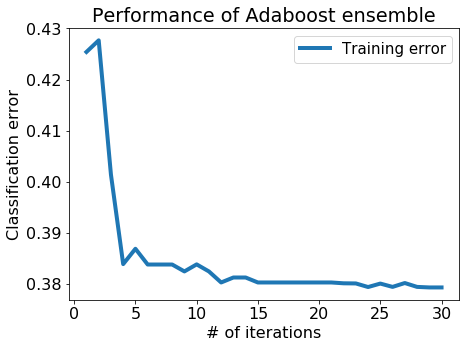

In [44]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

Training error goes down monotonically, i.e. the training error reduces with each iteration but never increases.

### Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Here, we will compute the classification error on the `test_data` at the end of each iteration.

In [43]:
true_label = test_data[target]
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost( stump_weights[:n], tree_stumps[:n], test_data )
    error = (predictions!=true_label).sum() / float(len(true_label))
    test_error_all.append(error)
    print( "Iteration %s, test error = %s" % (n, test_error_all[n-1]) )

Iteration 1, test error = 0.4313174946
Iteration 2, test error = 0.429481641469
Iteration 3, test error = 0.405939524838
Iteration 4, test error = 0.392980561555
Iteration 5, test error = 0.393304535637
Iteration 6, test error = 0.389848812095
Iteration 7, test error = 0.389848812095
Iteration 8, test error = 0.389848812095
Iteration 9, test error = 0.388768898488
Iteration 10, test error = 0.389956803456
Iteration 11, test error = 0.388768898488
Iteration 12, test error = 0.386933045356
Iteration 13, test error = 0.388336933045
Iteration 14, test error = 0.388336933045
Iteration 15, test error = 0.386933045356
Iteration 16, test error = 0.386933045356
Iteration 17, test error = 0.386933045356
Iteration 18, test error = 0.386933045356
Iteration 19, test error = 0.386933045356
Iteration 20, test error = 0.386933045356
Iteration 21, test error = 0.386933045356
Iteration 22, test error = 0.388012958963
Iteration 23, test error = 0.388012958963
Iteration 24, test error = 0.387041036717
Ite

### Visualize both the training and test errors

Now, let us plot the training & test error with the number of iterations.

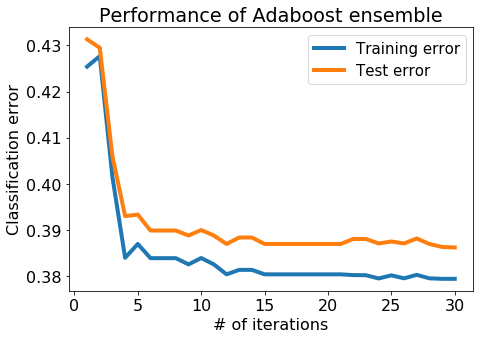

In [45]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

From this plot (with 30 trees), there is no massive overfitting as the # of iterations increases.